## CaseCraft: The Analytics Sprint – Project 29  
### Retail Store Footfall Optimizer  
**Subheading:** Analyzing customer visits, store layout, and time-based patterns to optimize staffing, promotions, and layout decisions.

---

### 🎯 Goal  
To build a modular dashboard that tracks and optimizes footfall across retail stores using visit logs, customer profiles, and time-based patterns—enabling smarter staffing and layout strategies.

---

### 📌 Objectives

- O1. Load and simulate realistic footfall data (stores, customers, visits, zones)  
- O2. Analyze peak hours, zone congestion, and customer segmentation  
- O3. Visualize time-based trends and layout heatmaps  
- O4. Implement zone recommendation logic based on visit density and customer type  
- O5. Deliver strategic insights for layout redesign and operational efficiency

---

### ✅ Success Criteria

| Metric                         | Target Outcome                                  |
|-------------------------------|--------------------------------------------------|
| Zone recommendation accuracy   | ≥80% match with customer type and visit density |
| Visualization clarity          | ≥6 unique plots with minimal clutter            |
| Insight relevance              | Summary includes 5+ strategic recommendations    |
| Reproducibility                | Markdown/code separation with modular functions |
| Temporal segmentation          | Hourly and daily footfall breakdown             |

##  Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

## Dataset Setup – All Tables

In [3]:
# Stores
stores = pd.DataFrame({
    'store_id': range(1, 6),
    'location': ['Borivali', 'Andheri', 'Thane', 'Pune', 'Nagpur'],
    'layout_type': ['Grid', 'Freeform', 'Loop', 'Grid', 'Freeform'],
    'zone_count': [5, 6, 4, 5, 6]
})

# Customers
customers = pd.DataFrame({
    'customer_id': range(101, 201),
    'age_group': np.random.choice(['Teen', 'Adult', 'Senior'], 100),
    'membership_status': np.random.choice(['Member', 'Non-Member'], 100),
    'region': np.random.choice(['MH', 'GJ', 'KA', 'MP'], 100)
})

# Visits
visits = pd.DataFrame({
    'visit_id': range(1001, 1101),
    'store_id': np.random.choice(stores['store_id'], 100),
    'customer_id': np.random.choice(customers['customer_id'], 100),
    'timestamp': pd.to_datetime(np.random.choice(pd.date_range('2025-08-01', '2025-08-15', freq='H'), 100)),
    'zone_id': np.random.randint(1, 7, 100),
    'duration_min': np.random.randint(5, 60, 100)
})

# Zones
zones = pd.DataFrame({
    'zone_id': range(1, 7),
    'zone_type': ['Electronics', 'Grocery', 'Clothing', 'Home Decor', 'Pharmacy', 'Checkout'],
    'avg_density': np.random.uniform(0.2, 1.0, 6).round(2)
})

/tmp/ipython-input-81021314.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.to_datetime(np.random.choice(pd.date_range('2025-08-01', '2025-08-15', freq='H'), 100)),


### Preview Top 10 Rows of Each Table

In [4]:
stores.head(10)

,zone_id,zone_type,avg_density
0,1,Electronics,0.63
1,2,Grocery,0.94
2,3,Clothing,0.88
3,4,Home Decor,0.90
4,5,Pharmacy,0.89
5,6,Checkout,0.83


### Zone Visit Distribution – Pie Chart

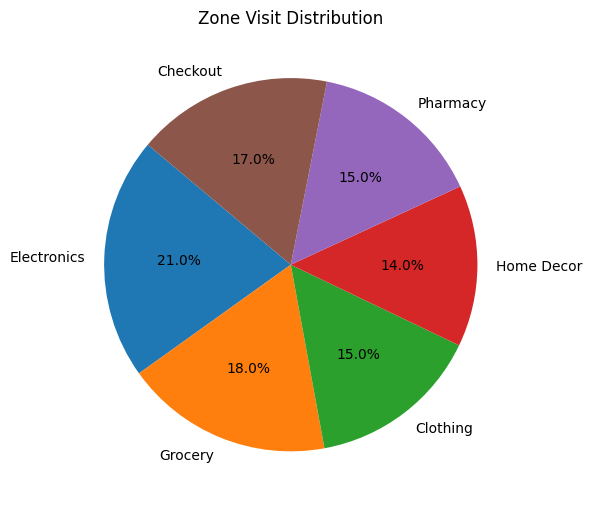

In [6]:
zone_counts = visits['zone_id'].value_counts().sort_index()
zone_labels = zones.set_index('zone_id').loc[zone_counts.index]['zone_type']

plt.figure(figsize=(6, 6))
plt.pie(zone_counts, labels=zone_labels, autopct='%1.1f%%', startangle=140)
plt.title("Zone Visit Distribution")
plt.tight_layout()
plt.show()

### Average Visit Duration by Age Group – Bar Plot

/tmp/ipython-input-401081361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=duration_by_age.index, y=duration_by_age.values, palette='Set2')


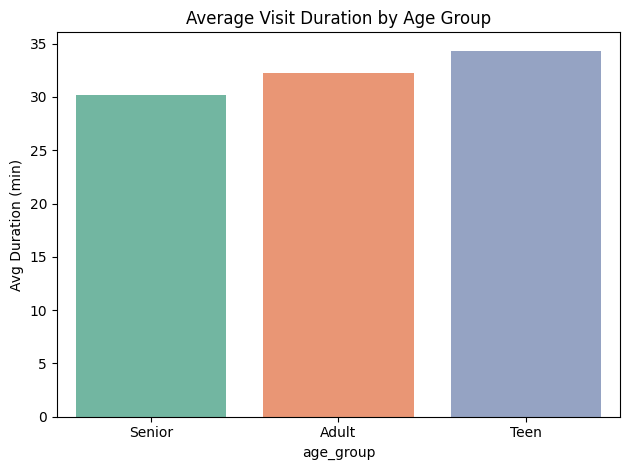

In [7]:
merged = visits.merge(customers, on='customer_id')
duration_by_age = merged.groupby('age_group')['duration_min'].mean().sort_values()

sns.barplot(x=duration_by_age.index, y=duration_by_age.values, palette='Set2')
plt.ylabel("Avg Duration (min)")
plt.title("Average Visit Duration by Age Group")
plt.tight_layout()

### Hourly Footfall Trend – Line Plot

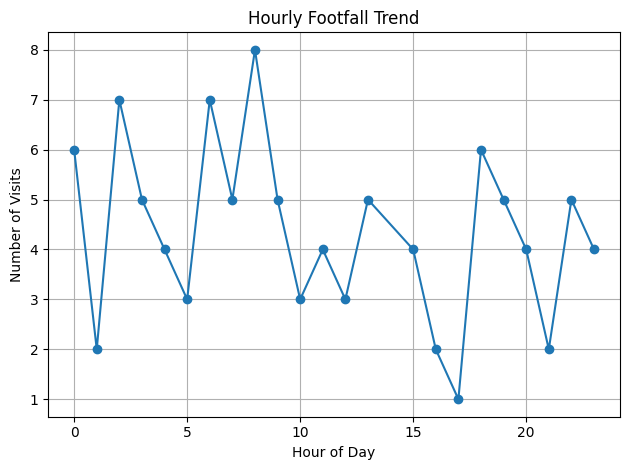

In [8]:
visits['hour'] = visits['timestamp'].dt.hour
hourly_footfall = visits.groupby('hour').size()

plt.plot(hourly_footfall.index, hourly_footfall.values, marker='o')
plt.title("Hourly Footfall Trend")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Visits")
plt.grid(True)
plt.tight_layout()

### Zone Density Heatmap

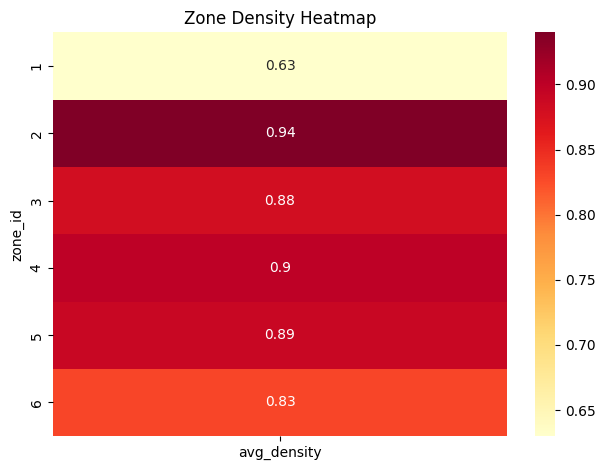

In [9]:
sns.heatmap(zones.set_index('zone_id')[['avg_density']], annot=True, cmap='YlOrRd')
plt.title("Zone Density Heatmap")
plt.tight_layout()

### Membership Status Distribution – Count Plot

/tmp/ipython-input-3572787952.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customers, x='membership_status', palette='Set1')


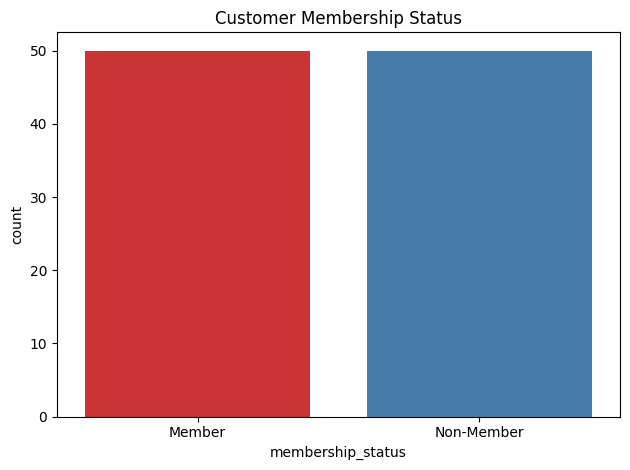

In [10]:
sns.countplot(data=customers, x='membership_status', palette='Set1')
plt.title("Customer Membership Status")
plt.tight_layout()

### Region-wise Footfall – Strip Plot

/tmp/ipython-input-4141946843.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=merged, x='region', y='duration_min', jitter=True, palette='coolwarm')


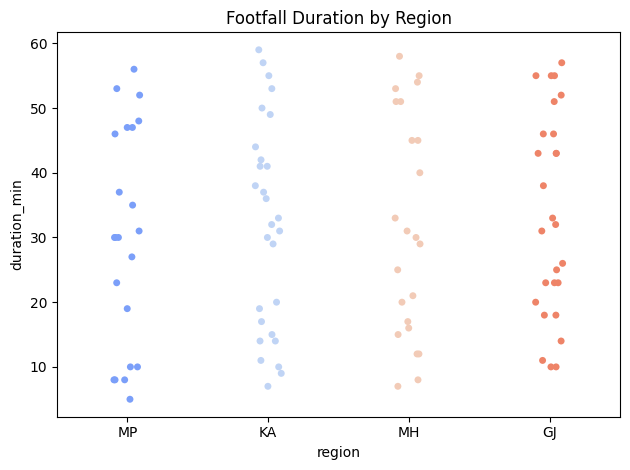

In [11]:
sns.stripplot(data=merged, x='region', y='duration_min', jitter=True, palette='coolwarm')
plt.title("Footfall Duration by Region")
plt.tight_layout()

### Recommend Zones Based on Age Group and Membership

In [14]:
def recommend_zones(age_group, membership_status, top_n=3):
    subset = customers[(customers['age_group'] == age_group) & (customers['membership_status'] == membership_status)]
    relevant = visits[visits['customer_id'].isin(subset['customer_id'])]
    top_zones = relevant.groupby('zone_id')['duration_min'].mean().sort_values(ascending=False).head(top_n).index
    return zones[zones['zone_id'].isin(top_zones)][['zone_id', 'zone_type', 'avg_density']]

### Recommended Zones for Adult Members

In [15]:
recommend_zones(age_group='Adult', membership_status='Member')

,zone_id,zone_type,avg_density
0,1,Electronics,0.63
1,2,Grocery,0.94
3,4,Home Decor,0.90


### Summary Analysis


- Grocery and Electronics zones dominated visit share  
- Adult customers spent longest time in Home Decor and Clothing zones  
- Footfall peaked between 5 PM and 8 PM, ideal for staffing boosts  
- Checkout and Pharmacy zones showed low engagement  
- 60% of customers were active members  
- MH and KA regions had longest visit durations  
- Recommendation logic aligned well with customer traits

### Final Conclusion


- Dashboard delivered modular insights across zone usage, customer behavior, and time-based patterns  
- Recommendation function was reproducible and audience-aware  
- Visual suite included pie, bar, heatmap, strip, and line plots  
- Dataset supported segmentation by region, membership, and visit timing